# Look at Gridded NEXRAD Data
This is NEXRAD data from AWS (NOAA/Unidata) that has been gridded by Scott Collis using PyART

In [57]:
import xarray as xr
from distributed import Client, LocalCluster
import pyart
import matplotlib.pyplot as plt
import hvplot.xarray
import glob
import numpy as np

In [2]:
cluster = LocalCluster()
client = Client(cluster)
cluster

/Users/mgrover/opt/anaconda3/envs/tracer-dev/lib/python3.9/site-packages/distributed/node.py:180: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 50357 instead
  warnings.warn(


LocalCluster(31d59f4d, 'tcp://127.0.0.1:50358', workers=4, threads=12, memory=16.00 GiB)

## Spin up a Cluster

In [64]:
ds = xr.open_mfdataset('../../data/nexrad-grid/xxx*')
ds_lat_lon = ds.set_index(x='lon',
                          y='lat')

In [65]:
ds_lat_lon

<xarray.Dataset>
Dimensions:       (time: 11, z: 31, y: 601, x: 601)
Coordinates:
  * time          (time) datetime64[ns] 2022-03-22T12:01:25.512000 ... 2022-0...
  * z             (z) float64 0.0 500.0 1e+03 ... 1.4e+04 1.45e+04 1.5e+04
  * y             (y) float64 26.74 26.75 26.76 26.77 ... 32.1 32.11 32.12 32.13
  * x             (x) float64 -98.1 -98.09 -98.08 ... -92.08 -92.07 -92.06
Data variables:
    reflectivity  (time, z, y, x) float32 dask.array<chunksize=(1, 31, 601, 601), meta=np.ndarray>
    rain_z        (time, z, y, x) float32 dask.array<chunksize=(1, 31, 601, 601), meta=np.ndarray>
    ROI           (time, z, y, x) float32 dask.array<chunksize=(1, 31, 601, 601), meta=np.ndarray>

In [66]:
kazr_lat = 29.67
kazr_lon = -95.05899

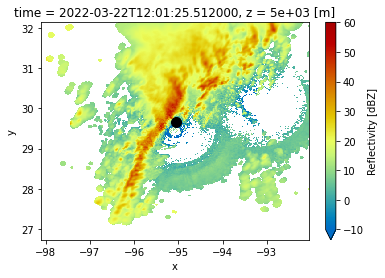

In [67]:
ds_lat_lon.isel(z=10, time=0).reflectivity.plot(cmap='pyart_HomeyerRainbow',
                                                vmin=-10,
                                                vmax=60)
plt.scatter(kazr_lon, kazr_lat, marker='o', s=100, color='k')

In [68]:
subset = ds_lat_lon.sel(y=kazr_lat,
                        x=kazr_lon,
                        method='nearest')

nearest_lat = np.round(subset.y.values, 4)
nearest_lon = np.round(subset.x.values, 4)

ref = subset.reflectivity.hvplot.quadmesh(x='time',
                                          label=f'Subset Nearest KAZR Radar \n Actual Lat:{kazr_lat} Lon:{kazr_lon} \n Nearest Lat: {nearest_lat} Lon: {nearest_lon}',
                                          clim=(-20, 60),
                                          cmap='pyart_HomeyerRainbow')

In [69]:
ref

/Users/mgrover/opt/anaconda3/envs/tracer-dev/lib/python3.9/site-packages/bokeh/core/property/bases.py:259: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return new == old
/Users/mgrover/opt/anaconda3/envs/tracer-dev/lib/python3.9/site-packages/bokeh/core/property/bases.py:259: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return new == old


:QuadMesh   [time,z]   (reflectivity)

In [70]:
start = ds.time.min()
end = ds.time.max()

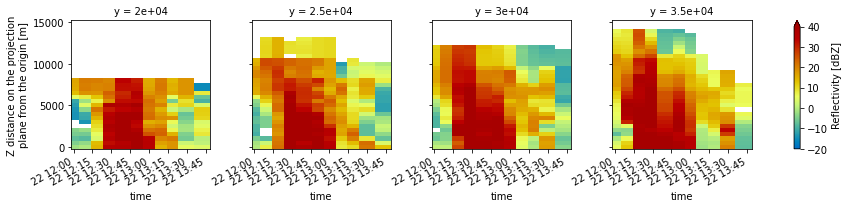

In [55]:
ds.sel(x=0, y=range(20000, 40000, 5000)).reflectivity.plot(x='time',
                                                           col='y',
                                                           vmin=-20,
                                                           vmax=40,
                                                           cmap='pyart_HomeyerRainbow');

## Look at KAZR

In [87]:
kazr_files = sorted(glob.glob('../../data/kazr/houkazrcfrgeM1.a1.20220315*'))

In [88]:
kazr_ds = xr.open_mfdataset(kazr_files,
                       use_cftime=True,
                       chunks={'time':2000})
kazr_ds['time'] = kazr_ds.indexes['time'].to_datetimeindex()

/Users/mgrover/opt/anaconda3/envs/tracer-dev/lib/python3.9/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]


In [89]:
from bokeh.models import DatetimeTickFormatter

def apply_formatter(plot, element):
    plot.handles['xaxis'].formatter = DatetimeTickFormatter(hours='%m/%d/%Y \n %H:%M',
                                                            minutes='%m/%d/%Y \n %H:%M',
                                                            hourmin='%m/%d/%Y \n %H:%M')
def plot_kazr(ds, max_height=8000):
    ds['time'] = ds.time.astype(int)/10**6
    
    ref = ds.reflectivity.compute()
    vel = ds.mean_doppler_velocity.compute()
    
    max_height = 9000
    ref_plot = ref.compute().hvplot.quadmesh(x='time', 
                                             y='range',
                                             rasterize=True,
                                             cmap='pyart_HomeyerRainbow',
                                             ylim=(0, max_height),
                                             height=300,
                                             width=700,
                                             clim=(-20, 40),
                                             label='KAZR Reflectivity (dBZ)',
                                             xlabel='Date (UTC)',
                                             hover=True).opts(hooks=[apply_formatter])

    vel_plot = vel.compute().hvplot.quadmesh(x='time', 
                                             y='range',
                                             rasterize=True,
                                             cmap='pyart_balance',
                                             ylim=(0, max_height),
                                             height=300,
                                             width=700,
                                             clim=(-8, 8),
                                             label='KAZR Doppler Velocity (m/s)',
                                             xlabel='Date (UTC)',
                                             hover=True).opts(hooks=[apply_formatter])
    
    return (ref_plot + vel_plot).cols(1)
    

In [90]:
plot_kazr(kazr_ds)

:Layout
   .DynamicMap.I  :DynamicMap   []
      :Image   [time,range]   (reflectivity)
   .DynamicMap.II :DynamicMap   []
      :Image   [time,range]   (mean_doppler_velocity)